In [14]:
!pip install fastparquet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet('/content/functions_df.parquet.gz', engine='fastparquet')
df = df.drop(columns=['Unnamed: 0'])
df.shape

(402913, 12)

# EDA
We perform an EDA for the obtained dataframe

In [15]:
def split_into_types(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    multiline_functions_df = df[(df.is_multiline == True) & (df.is_test == False)].reset_index(drop=True)
    abstract_functions_df = df[(df.is_abstract == True) & (df.is_test == False)].reset_index(drop=True)
    tests_df = df[df.is_test == True].reset_index(drop=True)
    one_liners_df = df[~df['function_id'].isin(multiline_functions_df['function_id']) &
                       ~df['function_id'].isin(abstract_functions_df['function_id']) &
                       ~df['function_id'].isin(tests_df['function_id'])].reset_index(drop=True)
    return multiline_functions_df, abstract_functions_df, tests_df, one_liners_df


multiline_functions_df, abstract_functions_df, tests_df, one_liners_df = split_into_types(df)
print(multiline_functions_df.shape)

(221810, 12)


In [16]:
def average_block_length(dataframe):
    dataframe['block_length'] = dataframe['block'].apply(lambda x: len(str(x).split('\n')))
    return dataframe['block_length'].mean()

# Assuming split_into_types returns the specified DataFrames
multiline_avg_length = average_block_length(multiline_functions_df)
abstract_avg_length = average_block_length(abstract_functions_df)
tests_avg_length = average_block_length(tests_df)
one_liners_avg_length = average_block_length(one_liners_df)

# Print or use the average lengths as needed
print("Average Block Length for Multiline Functions:", multiline_avg_length)
print("Average Block Length for Abstract Functions:", abstract_avg_length)
print("Average Block Length for Test Functions:", tests_avg_length)
print("Average Block Length for One-liners:", one_liners_avg_length)

Average Block Length for Multiline Functions: 11.487741760966593
Average Block Length for Abstract Functions: 1.0001946282600234
Average Block Length for Test Functions: 4.006319903538315
Average Block Length for One-liners: 2.7651597868422337


<ipython-input-17-90e032a5dbba>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


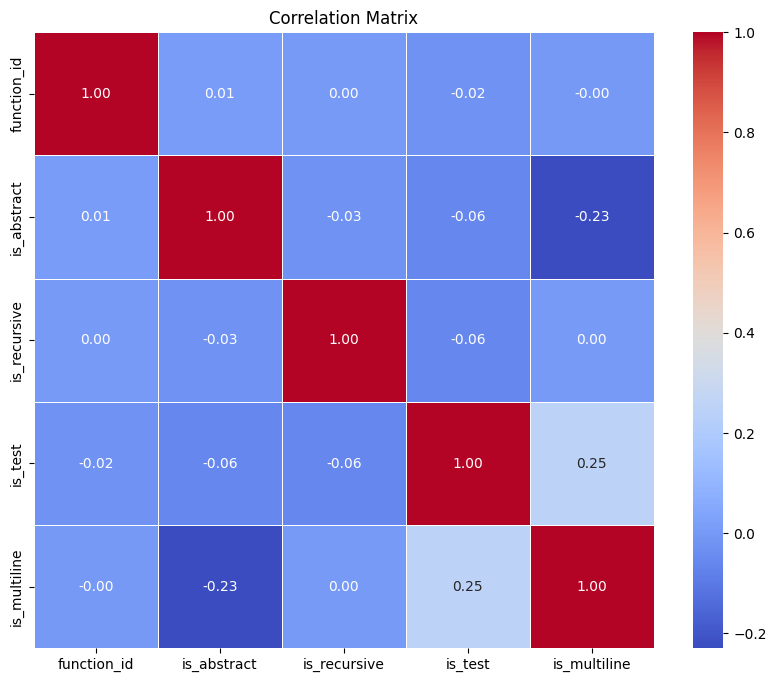

In [17]:
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

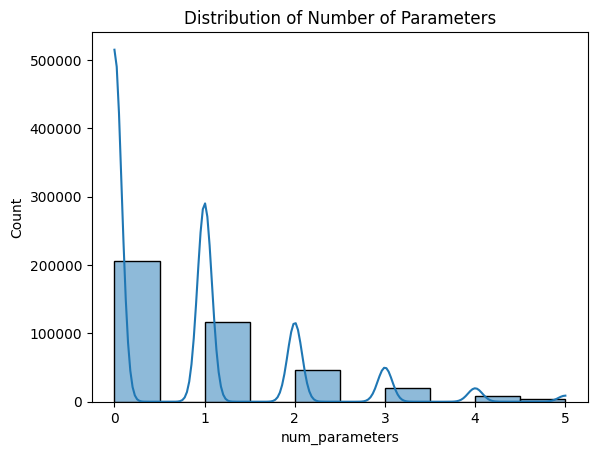


Number of functions with more than 5 parameters: 3062


In [28]:
df['block_length'] = df['block'].apply(lambda x: len(str(x).split('\n')))

def count_parameters(param_string):
    if pd.notnull(param_string):
        return len(param_string.split(','))
    else:
        return 0

df['num_parameters'] = df['formal_parameters'].apply(count_parameters)
show_df = df[df['num_parameters'] <= 5]
sns.histplot(show_df['num_parameters'], bins=10, kde=True)
plt.title('Distribution of Number of Parameters')
plt.show()

print(f'\nNumber of functions with more than 5 parameters: {len(df[df["num_parameters"] > 5])}')

# Error analysis
I saved all results of evaluation of the predictions so lets analyze it

In [138]:
import re

def extract_tokens_from_camel(text: str, is_lower: bool = True) -> list[str] | str:
    try:
        if len(text.split('_')) > 1:
            return text.split('_')
        else:
            return [i.lower() if is_lower else i for i in re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)', text)]
    except:
        return ''

In [156]:
error_analysis_data = {
    'Function Type': [],
    'Full Correct Predictions': [],
    'Totally Incorrect Predictions': [],
    'Partial Correct Predictions': []
}


def analyze_errors(dataframe, func_type):
  dataframe['error_size'] = dataframe.apply(lambda row: len(set(extract_tokens_from_camel(row['label'])) -
                                              set(extract_tokens_from_camel(row['prediction']))),
                              axis=1)
  dataframe['label_size'] = dataframe.apply(lambda row: len(extract_tokens_from_camel(row['label'])), axis=1)

  correct_pred = len(dataframe[dataframe["error_size"] == 0])
  print(f'\tPercentage of full correct predictions: {round(100 * correct_pred/len(dataframe), 4)}%')

  incorrect_pred = len(dataframe[dataframe["error_size"] == dataframe["label_size"]])
  print(f'\tPercentage of totally incorrect predictions: {round(100 * incorrect_pred/len(dataframe), 4)}%')

  partial_correct_pred = len(dataframe) - correct_pred - incorrect_pred
  print(f'\tPercentage of partial correct predictions: {round(100 * partial_correct_pred/len(dataframe), 4)}%')

  diff = dataframe['label_size'] - dataframe['error_size']
  print("\tMean number of incorrect predicted tokens:", diff.mean())
  print()

  error_analysis_data['Function Type'].append(func_type)
  error_analysis_data['Full Correct Predictions'].append(round(100 * correct_pred/len(dataframe), 4))
  error_analysis_data['Totally Incorrect Predictions'].append(round(100 * incorrect_pred/len(dataframe), 4))
  error_analysis_data['Partial Correct Predictions'].append(round(100 * partial_correct_pred/len(dataframe), 4))

In [157]:
def plot_errors(data, title):
  error_df = pd.DataFrame(data)
  error_df_melted = pd.melt(error_df, id_vars='Function Type', var_name='Error Type', value_name='Percentage')
  sns.set(style="whitegrid")

  plt.figure(figsize=(16, 9))
  barplot = sns.barplot(x='Function Type', y='Percentage', hue='Error Type', data=error_df_melted, palette='viridis')

  plt.title(title)
  plt.xlabel('Function Type')
  plt.ylabel('Percentage')
  plt.ylim(0, 100)

  plt.legend(title='Error Type', bbox_to_anchor=(1, 1))

  for p in barplot.patches:
      barplot.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 10), textcoords='offset points')
  plt.show()

In [158]:
multiline_pretrained = pd.read_csv('/content/result_multiline.csv')
print('Error analysis for MULTILINE functions (on pretrained model)')
analyze_errors(multiline_pretrained, 'MULTILINE')

abstract_pretrained = pd.read_csv('/content/result_abstract.csv')
print('Error analysis for ABSTRACT functions (on pretrained model)')
analyze_errors(abstract_pretrained, 'ABSTRACT')

oneline_pretrained = pd.read_csv('/content/result_oneline.csv')
print('Error analysis for ONE-LINE functions (on pretrained model)')
analyze_errors(oneline_pretrained, 'ONE-LINE')

tests_pretrained = pd.read_csv('/content/result_tests.csv')
print('Error analysis for TEST functions (on pretrained model)')
analyze_errors(tests_pretrained, 'TEST')

Error analysis for MULTILINE functions (on pretrained model)
	Percentage of full correct predictions: 24.65%
	Percentage of totally incorrect predictions: 31.7%
	Percentage of partial correct predictions: 43.65%
	Mean number of incorrect predicted tokens: 1.16

Error analysis for ABSTRACT functions (on pretrained model)
	Percentage of full correct predictions: 2.5%
	Percentage of totally incorrect predictions: 60.9%
	Percentage of partial correct predictions: 36.6%
	Mean number of incorrect predicted tokens: 0.518

Error analysis for ONE-LINE functions (on pretrained model)
	Percentage of full correct predictions: 25.45%
	Percentage of totally incorrect predictions: 27.9%
	Percentage of partial correct predictions: 46.65%
	Mean number of incorrect predicted tokens: 1.2945

Error analysis for TEST functions (on pretrained model)
	Percentage of full correct predictions: 43.05%
	Percentage of totally incorrect predictions: 8.55%
	Percentage of partial correct predictions: 48.4%
	Mean numb

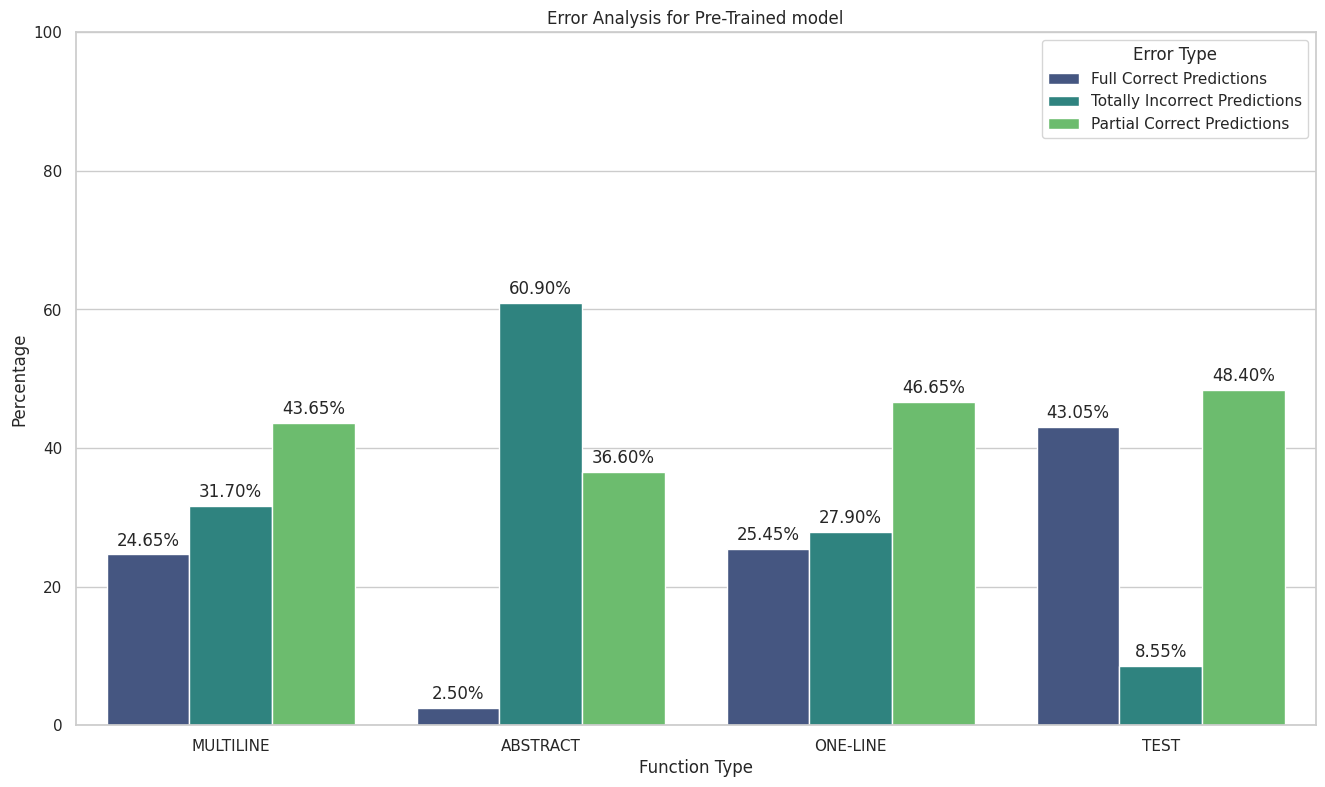

In [159]:
plot_errors(error_analysis_data, 'Error Analysis for Pre-Trained model')

In [160]:
error_analysis_data = {'Function Type': [], 'Full Correct Predictions': [], 'Totally Incorrect Predictions': [], 'Partial Correct Predictions': []}

multiline_pretrained = pd.read_csv('/content/ft_result_multiline.csv')
print('Error analysis for MULTILINE functions (on pretrained model)')
analyze_errors(multiline_pretrained, 'MULTILINE')

abstract_pretrained = pd.read_csv('/content/ft_result_abstract.csv')
print('Error analysis for ABSTRACT functions (on pretrained model)')
analyze_errors(abstract_pretrained, 'ABSTRACT')

oneline_pretrained = pd.read_csv('/content/ft_result_oneline.csv')
print('Error analysis for ONE-LINE functions (on pretrained model)')
analyze_errors(oneline_pretrained, 'ONE-LINE')

tests_pretrained = pd.read_csv('/content/ft_result_tests.csv')
print('Error analysis for TEST functions (on pretrained model)')
analyze_errors(tests_pretrained, 'TEST')

Error analysis for MULTILINE functions (on pretrained model)
	Percentage of full correct predictions: 41.5%
	Percentage of totally incorrect predictions: 16.7%
	Percentage of partial correct predictions: 41.8%
	Mean number of incorrect predicted tokens: 1.5965

Error analysis for ABSTRACT functions (on pretrained model)
	Percentage of full correct predictions: 28.7%
	Percentage of totally incorrect predictions: 26.95%
	Percentage of partial correct predictions: 44.35%
	Mean number of incorrect predicted tokens: 1.2

Error analysis for ONE-LINE functions (on pretrained model)
	Percentage of full correct predictions: 52.55%
	Percentage of totally incorrect predictions: 13.7%
	Percentage of partial correct predictions: 33.75%
	Mean number of incorrect predicted tokens: 1.853

Error analysis for TEST functions (on pretrained model)
	Percentage of full correct predictions: 63.7%
	Percentage of totally incorrect predictions: 4.5%
	Percentage of partial correct predictions: 31.8%
	Mean number

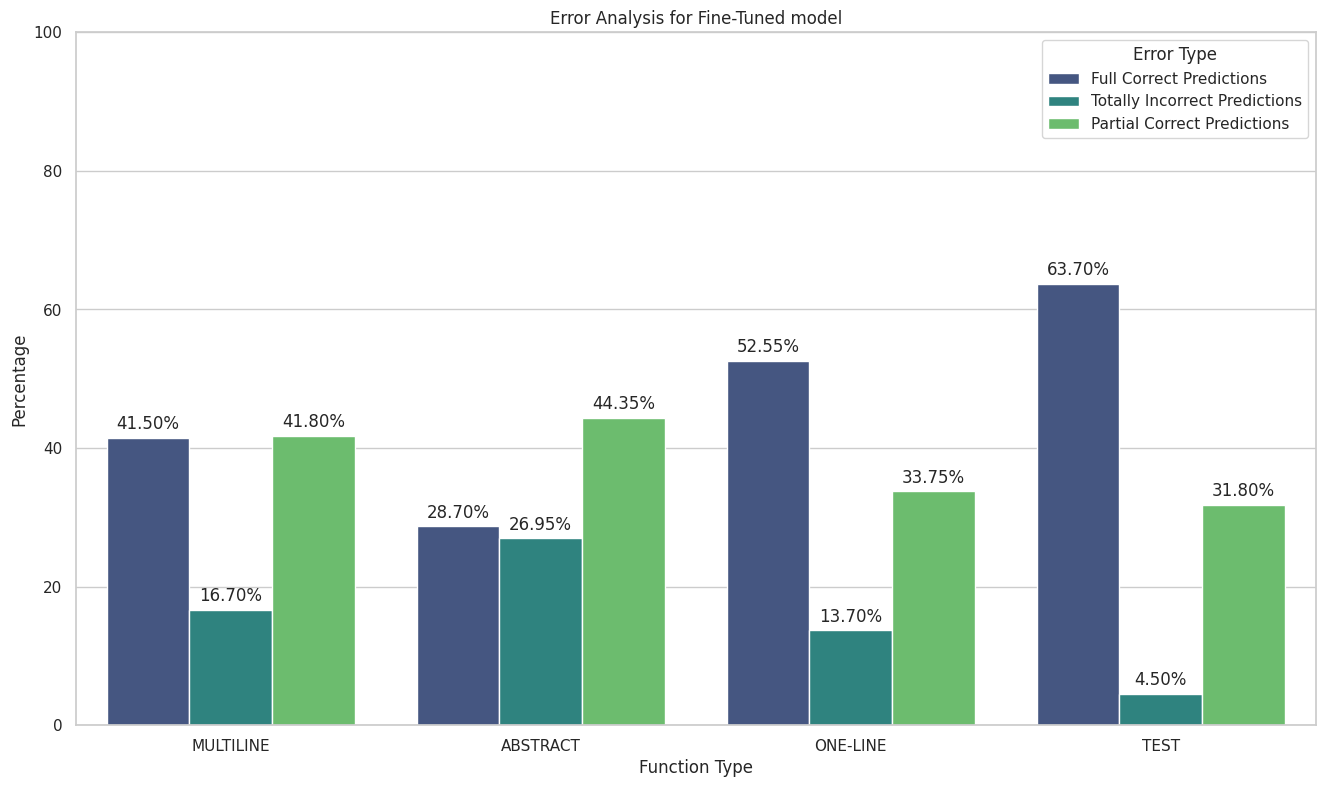

In [161]:
plot_errors(error_analysis_data, 'Error Analysis for Fine-Tuned model')